<img src="../Images/DSC_Logo.png" style="width: 400px;">

# Time Series Theory in Python - Part 4: Regression and Advanced Models

This notebook demonstrates time series regression and introduces exemplary advanced modeling techniques for time series prediction.

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import statsmodels.api as sm
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.inspection import permutation_importance

from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GRU, Dense
from tensorflow.keras.layers import LSTM

from PythonTsa.datadir import getdtapath
dtapath=getdtapath()

2024-11-06 17:51:50.177457: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-11-06 17:51:50.204939: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-11-06 17:51:51.456997: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-11-06 17:51:51.969668: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1730915512.303953      63 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1730915512.45

## 1 Time Series Regression Techniques

### **Example 1: Australian Employed Total Persons**

m: 13.602135980778947 n: 5548.400261772608


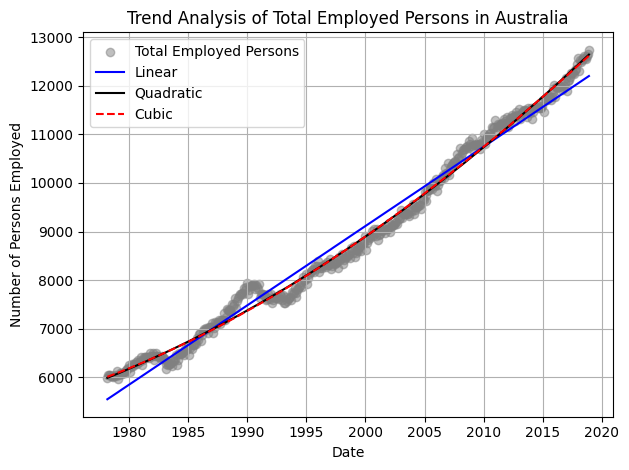

Linear Model Summary:
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.982
Model:                            OLS   Adj. R-squared:                  0.982
Method:                 Least Squares   F-statistic:                 2.637e+04
Date:                Wed, 06 Nov 2024   Prob (F-statistic):               0.00
Time:                        17:52:01   Log-Likelihood:                -3423.3
No. Observations:                 490   AIC:                             6851.
Df Residuals:                     488   BIC:                             6859.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       5548.4003     23.6

In [3]:
# Get the data file path
dtapath = getdtapath()

# Load the Excel file containing employment data
aul = pd.read_excel(dtapath + 'AustraliaEmployedTotalPersons.xlsx', header=0)

# Create a time index starting from February 1978 with monthly frequency
timeindex = pd.date_range('1978-02', periods=len(aul), freq='ME')
aul.index = timeindex

# Extracting employed persons
y = aul['EmployedP'].values
time = np.arange(len(y))  # Create an array of time periods (0, 1, 2, ...)

# Fit OLS models
linear_model = sm.OLS(y, sm.add_constant(time)).fit()
quadratic_model = sm.OLS(y, sm.add_constant(np.column_stack((time, time**2)))).fit()
cubic_model = sm.OLS(y, sm.add_constant(np.column_stack((time, time**2, time**3)))).fit()

# Extracting the slope and intercept for the linear model
slope = linear_model.params[1]  
intercept = linear_model.params[0] 
print("m:", slope, "n:", intercept)

# Plotting the results
plt.figure()
plt.scatter(aul.index, y, label='Total Employed Persons', color='gray', alpha=0.5)

# Fitted values from each model
plt.plot(aul.index, linear_model.fittedvalues, label='Linear', color='blue')
plt.plot(aul.index, quadratic_model.fittedvalues, label='Quadratic', color='black')
plt.plot(aul.index, cubic_model.fittedvalues, label='Cubic', color='red', linestyle='--')

# Adding titles and labels
plt.title('Trend Analysis of Total Employed Persons in Australia')
plt.xlabel('Date')
plt.ylabel('Number of Persons Employed')
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()

# Print the summary statistics for models
print("Linear Model Summary:")
print(linear_model.summary())
print("\nQuadratic Model Summary:")
print(quadratic_model.summary())
print("\nCubic Model Summary:")
print(cubic_model.summary())

When comparing models, AIC helps identify which trend model balances goodness-of-fit with simplicity, where lower values suggest a more efficient model. Additionally, the adjusted R-squared provides information how well the model explains the variance in the data.

In [4]:
print("\nModel Comparison:")
print(f"Linear Model - AIC: {linear_model.aic:.2f}, Adjusted R-squared: {linear_model.rsquared_adj:.4f}")
print(f"Quadratic Model - AIC: {quadratic_model.aic:.2f}, Adjusted R-squared: {quadratic_model.rsquared_adj:.4f}")
print(f"Cubic Model - AIC: {cubic_model.aic:.2f}, Adjusted R-squared: {cubic_model.rsquared_adj:.4f}")


Model Comparison:
Linear Model - AIC: 6850.61, Adjusted R-squared: 0.9818
Quadratic Model - AIC: 6435.12, Adjusted R-squared: 0.9922
Cubic Model - AIC: 6436.02, Adjusted R-squared: 0.9922


### **Example 2: Mean Spring Passage Dates of European Pied Flycatcher**

The dataset contains the migration data of the European Pied Flycatcher, focusing on the adjusted mean spring passage dates (MADJDAYSWS) across multiple years. The dataset includes annual observations, capturing trends in migration timing and the relationship between migration timing and several influential climate variables from key geographic regions.

Identified final weather variables that are likely to affect mean spring passage dates at Helgoland of the European Pied Flycatcher:
- ID14: mean temperature in a specific region Germany (23 Mar - 14 May)
- ID25: number of days with winds coming from Helgoland in a region in Mali (09 Feb - 09 Jun)
- ID15: mean temperature in a specific region in Italy (27 Nov - 12 Dec)
- ID8: mean temperature in the region of northwestern Algeria and northeastern Marocco (10 Feb - 08 Jun)
- ID53: number of days with winds going to Helgoland in a region in Nigeria (16 Apr - 05 May)

**Original dataset and code:** Haest, B., Hüppop, O., & Bairlein, F. (2020). Code and data for: "Weather at the winter and stopover areas determines spring migration onset, progress, and advancements in Afro-Palearctic migrant birds". In Proceedings of the National Academy of Sciences of the United States of America (v1.0, Bd. 117, Nummer 29, S. 17056–17062). Zenodo. doi:10.5281/zenodo.3629178              

**Related publication(s):** Haest, B., Hüppop, O., and Bairlein, F.: Weather at the winter and stopover areas determines spring migration onset, progress, and advancements in Afro-Palearctic migrant birds, Proceedings of the National Academy of Sciences, 117, 17056–17062, doi:10.1073/pnas.1920448117,              2020.

Original data and code were modified for this notebook.

In [5]:
bird_migration = pd.read_csv('../Datasets/bird_migration.csv', sep = ';')
bird_migration.head()

,Year,MADJDAYSWS,ID14,ID25,ID15,ID8,ID53
0,1960,146.935484,7.649996,55,11.934368,14.720795,3
1,1961,142.620438,9.332543,45,12.440621,15.084240,6
2,1962,146.184211,7.868393,65,12.192183,14.565542,6
3,1963,155.965517,7.916978,83,9.785934,13.021634,4
4,1964,148.109375,8.480657,83,11.723433,15.679198,5


The study fitted regression lines to the mean spring passage dates, modeling the trend in MSPD using just the temporal aspect (e.g., the effect of the year) to understand how the MSPD changes over time.

m: -0.21233020362914967 n: 566.7310520038468


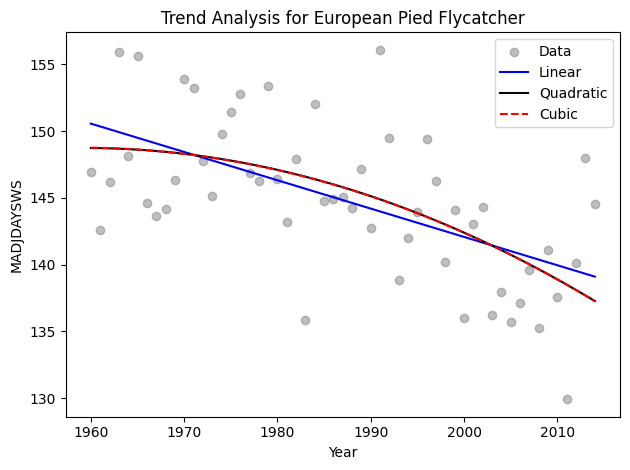

In [6]:
# Assuming the 'MADJDAYSWS' is the column we want as y
y2 = bird_migration['MADJDAYSWS'].values  # Extracting dependent variable
time2 = bird_migration['Year'].values  # Using the Year column as the time variable

# Fit OLS models
linear_model = sm.OLS(y2, sm.add_constant(time2)).fit()
quadratic_model = sm.OLS(y2, sm.add_constant(np.column_stack((time2, time2**2)))).fit()
cubic_model = sm.OLS(y2, sm.add_constant(np.column_stack((time2, time2**2, time2**3)))).fit()

# Extracting the slope and intercept for the linear model
slope = linear_model.params[1]  
intercept = linear_model.params[0] 
print("m:", slope, "n:", intercept)

# Plotting the results
plt.figure()
plt.scatter(bird_migration['Year'], y2, label='Data', color='gray', alpha=0.5)
plt.plot(time2, linear_model.fittedvalues, label='Linear', color='blue')
plt.plot(time2, quadratic_model.fittedvalues, label='Quadratic', color='black')
plt.plot(time2, cubic_model.fittedvalues, label='Cubic', color='red', linestyle='--')
plt.legend()
plt.xlabel('Year')
plt.ylabel('MADJDAYSWS')
plt.title('Trend Analysis for European Pied Flycatcher')
plt.tight_layout()
plt.show()

In [7]:
print("\nModel Comparison:")
print(f"Linear Model - AIC: {linear_model.aic:.2f}, Adjusted R-squared: {linear_model.rsquared_adj:.4f}")
print(f"Quadratic Model - AIC: {quadratic_model.aic:.2f}, Adjusted R-squared: {quadratic_model.rsquared_adj:.4f}")
print(f"Cubic Model - AIC: {cubic_model.aic:.2f}, Adjusted R-squared: {cubic_model.rsquared_adj:.4f}")


Model Comparison:
Linear Model - AIC: 329.38, Adjusted R-squared: 0.3311
Quadratic Model - AIC: 329.46, Adjusted R-squared: 0.3416
Cubic Model - AIC: 329.49, Adjusted R-squared: 0.3413


Birds arrive earlier. The linear model yielded the lowest AIC of 329.38, indicating it is the best fit among the three models, despite the relatively low adjusted R-squared of 0.3311, suggesting that approximately 33% of the variability in the migration timing is explained by the model. 

### Linear regression with explanatory variables

The following code block prepares the data for a prediction task where MSPD shall be predicted using five pre-selected explanatory variables. 

The dataset is splitted into a training set for fitting the regression model and a testing set for evaluating its performance using `train_test_split`. It is generally recommended to use a **training, validation, and test split** for most types of predictive modeling. Datasets are typically divided into three parts: the train set, validation set, and test set. These sets do not overlap. This approach ensures a robust evaluation of the performance of model in unseen data. A two-split approach (training and validation) can be sufficient depending on the research question. 

After fitting the Linear Regression model to the training data using `LinearRegression`, predictions are made on the test set. The coefficients of the model are printed, providing insights into the relationship between the features and the target variable. **Feature importance** is analyzed using `permutation_importance` as an example. The permutation feature importance  allows us to assess the impact of each feature on the model's predictive performance by randomly shuffling the feature values and measuring the change in prediction accuracy. For the permutation feature importance, it is important that the features are uncorrelated with each other. 

Note: Both `OLS` (statsmodels library) and `LinearRegression` (scikit-learn library) implement the ordinary least squares method, leading to similar linear regression results (i.e., the estimated coefficients will be the same in theory). However, the way they present the results and the additional functionalities they offer (statistical diagnostics vs. prediction/machine learning workflow) differ.

Model coefficients:
ID14: -1.0455465865273799
ID25: 0.09980245494574391
ID15: -1.2366819488395318
ID8: -1.5957380729256372
ID53: -0.5354652462839893
Feature ranking:
1. Feature ID25 (0.11617127012248854)
2. Feature ID14 (0.06842797917044048)
3. Feature ID15 (0.06503897600080026)
4. Feature ID53 (0.00968100795191935)
5. Feature ID8 (0.008463271888844374)


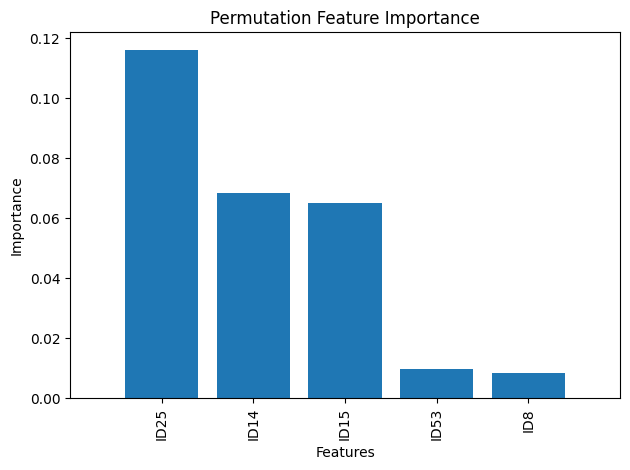

In [8]:
# Extracting the dependent variable and the features
y2 = bird_migration['MADJDAYSWS'].values  # Target variable
X = bird_migration[['ID14', 'ID25', 'ID15', 'ID8', 'ID53']]  # Features

# Splitting the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y2, test_size=0.2, random_state=42)

# Train a Linear Regression model
linear_model = LinearRegression()
linear_model.fit(X_train, y_train)

# Predict on the test set
y_pred = linear_model.predict(X_test)

# Print model coefficients
print("Model coefficients:")
for i, col in enumerate(X.columns):
    print(f"{col}: {linear_model.coef_[i]}")

# Calculate permutation feature importance
result = permutation_importance(linear_model, X_test, y_test, n_repeats=30, random_state=42)

# Get feature importance
importance = result.importances_mean
indices = np.argsort(importance)[::-1]

# Print feature ranking
print("Feature ranking:")
for i in range(X.shape[1]):
    print(f"{i + 1}. Feature {X.columns[indices[i]]} ({importance[indices[i]]})")

# Visualize feature importance
plt.figure()
plt.title("Permutation Feature Importance")
plt.bar(range(X.shape[1]), importance[indices], align="center")
plt.xticks(range(X.shape[1]), X.columns[indices], rotation=90)
plt.xlim([-1, X.shape[1]])
plt.ylabel("Importance")
plt.xlabel("Features")
plt.tight_layout()
plt.show()

Interpretation:
- ID25: Mali (Wind - Coming From Helgoland, 09 Feb - 09 Jun): Identified as the most important factor for predicting migration timing, with a feature importance score of 0.1162. Good winds from Helgoland at the wintering site help the birds travel faster, making them arrive earlier. Although we did not apply exactly the same methods as the study, this finding aligns with the study's finding that wind conditions, particularly in stopover and wintering sites, have a major influence on spring migration timing.
- ID14: Germany (Temperature, 23 Mar - 14 May): The temperature during this time affects when birds migrate, suggesting that warmer temperatures lead to earlier migrations.
- ...

## 2. Advanced Time Series Prediction Techniques

## 2.1 GAM

$$E(Y)=β0​+f1​(X1​)+f2​(X2​)+...+fk​(Xk​)$$


The Generalized Additive Model (GAM) employs flexible B-splines to create smooth fits for data, enabling it to capture non-linear relationships. This capacity allows GAMs to identify complex trends and patterns that simpler models might overlook.

### **Example 1 [continued]: Australian Employed Total Persons**

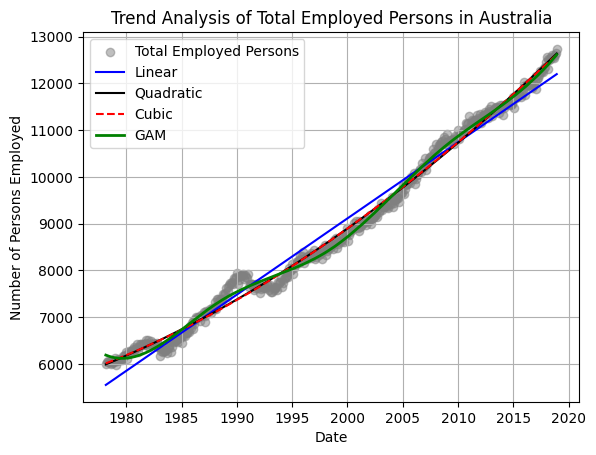

Linear Model Summary:
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.982
Model:                            OLS   Adj. R-squared:                  0.982
Method:                 Least Squares   F-statistic:                 2.637e+04
Date:                Wed, 06 Nov 2024   Prob (F-statistic):               0.00
Time:                        17:52:01   Log-Likelihood:                -3423.3
No. Observations:                 490   AIC:                             6851.
Df Residuals:                     488   BIC:                             6859.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       5548.4003     23.6

In [9]:
import statsmodels.api as sm
from patsy import dmatrix 

# Load the Excel file containing employment data
dtapath = getdtapath()
aul = pd.read_excel(dtapath + 'AustraliaEmployedTotalPersons.xlsx', header=0)

# Create a time index starting from February 1978 with monthly frequency
timeindex = pd.date_range('1978-02', periods=len(aul), freq='ME')
aul.index = timeindex

# Extracting employed persons
y = aul['EmployedP'].values
time = np.arange(len(y))  # Create an array of time periods (0, 1, 2, ...)

# Fit OLS models
linear_model = sm.OLS(y, sm.add_constant(time)).fit()
quadratic_model = sm.OLS(y, sm.add_constant(np.column_stack((time, time**2)))).fit()
cubic_model = sm.OLS(y, sm.add_constant(np.column_stack((time, time**2, time**3)))).fit()

# Fit a Generalized Additive Model (GAM) using B-splines
bsplines = dmatrix("bs(time, df=6)", {"time": time}, return_type='dataframe')
gam_model = sm.GLM(y, bsplines, family=sm.families.Gaussian()).fit()

# Plotting results
plt.figure()
plt.scatter(aul.index, y, label='Total Employed Persons', color='gray', alpha=0.5)

# Fitted values from each model
plt.plot(aul.index, linear_model.fittedvalues, label='Linear', color='blue')
plt.plot(aul.index, quadratic_model.fittedvalues, label='Quadratic', color='black')
plt.plot(aul.index, cubic_model.fittedvalues, label='Cubic', color='red', linestyle='--')
plt.plot(aul.index, gam_model.fittedvalues, label='GAM', color='green', linewidth=2)

# Adding titles and labels
plt.title('Trend Analysis of Total Employed Persons in Australia')
plt.xlabel('Date')
plt.ylabel('Number of Persons Employed')
plt.legend()
plt.grid()
plt.show()

# Print the summary statistics for models
print("Linear Model Summary:")
print(linear_model.summary())
print("\nQuadratic Model Summary:")
print(quadratic_model.summary())
print("\nCubic Model Summary:")
print(cubic_model.summary())
print("\nGAM Model Summary:")
print(gam_model.summary())

## 2.2 Neural Networks

### **Example 3: Hourly Series of Electricity Load**

The load series has at least three seasonal patterns: hourly (24 hours), monthly (12 months), and quarterly (4 quarters). Because of this complexity, fitting a traditional statistical model to the load series is challenging.

## 2.2.1 Dataset Preprocessing and Preparation

Preprocessing and preparing datasets for machine learning tasks generally involves scaling and splitting the dataset.

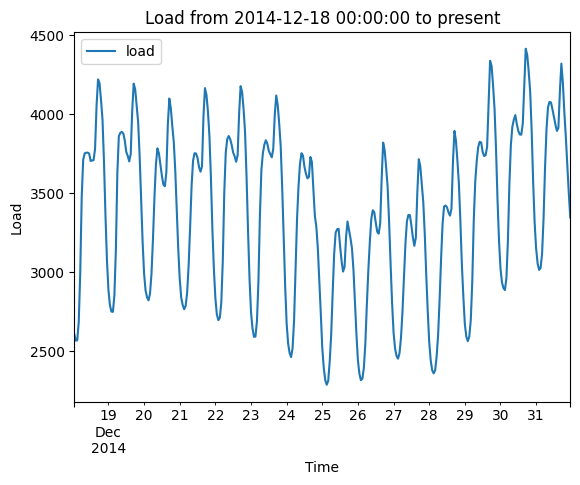

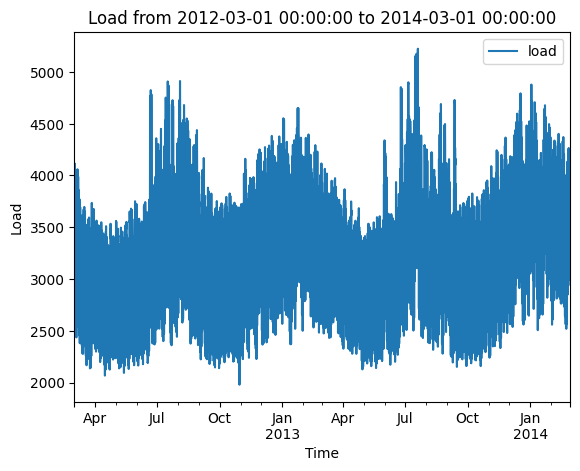

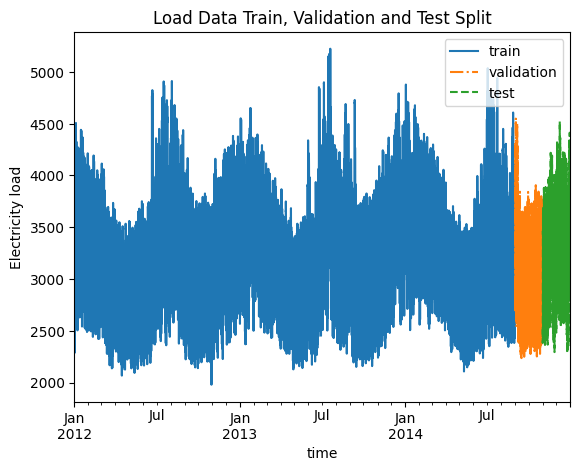

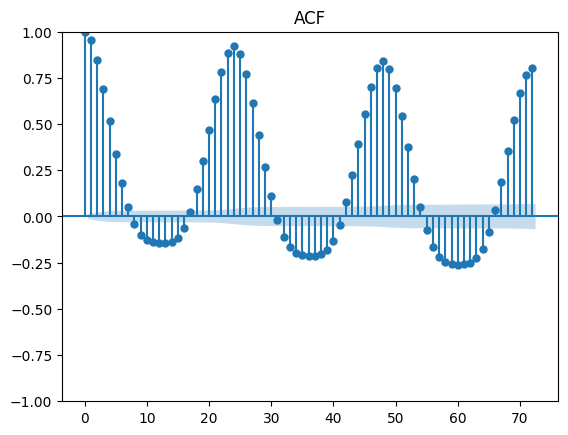

In [10]:
# Load the data
tsdta = pd.read_csv(dtapath + "elec-temp.csv")
tsdta['time'] = pd.to_datetime(tsdta['time'])
tsdta.set_index('time', inplace=True)

# Select "load" data
loadts = tsdta[['load']]  # Assuming the column is named 'load'

# Plot to see hourly seasonality
loadts2 = loadts[loadts.index > '2014-12-18 00:00:00']
loadts2.plot(title='Load from 2014-12-18 00:00:00 to present')
plt.xlabel('Time')
plt.ylabel('Load')
plt.show()

# Plot to see monthly and quarterly seasonality
loadts3 = loadts[(loadts.index > '2012-03-01 00:00:00') & (loadts.index < '2014-03-01 00:00:00')]
loadts3.plot(title='Load from 2012-03-01 00:00:00 to 2014-03-01 00:00:00')
plt.xlabel('Time')
plt.ylabel('Load')
plt.show()

# Splitting the datasets
validtime = '2014-09-01 00:00:00'
testtime = '2014-11-01 00:00:00'

loadts_split = (
    loadts[(loadts.index < validtime)].rename(columns={'load': 'train'})
    .join(loadts[(loadts.index >= validtime) & (loadts.index < testtime)]
           .rename(columns={'load': 'validation'}), how='outer')
    .join(loadts[testtime:].rename(columns={'load': 'test'}), how='outer')
)

# Plotting the train, validation, and test sets
loadts_split.plot(y=['train', 'validation', 'test'], style=['-', '-.', '--'])
plt.ylabel('Electricity load')
plt.title('Load Data Train, Validation and Test Split')
plt.show()

# Train/Validation/Test datasets
train = loadts.copy()[loadts.index < validtime]
valid = loadts.copy()[(loadts.index >= validtime) & (loadts.index < testtime)]
test = loadts.copy()[loadts.index >= testtime]

# Scaling the data
scaler = MinMaxScaler()
train['load'] = scaler.fit_transform(train)
valid['load'] = scaler.transform(valid)
test['load'] = scaler.transform(test)

# ACF of scaled data: still nonstationary
plot_acf(train['load'], lags=72)
plt.title('ACF')
plt.show()

In this preprocessing procedure, the dataset is manually split into training, validation, and test sets based on specific timestamps. This method is especially usefull for time series, because it retains the temporal ordering of the data. In contrast, the `train_test_split` function randomly partitions the dataset into two subsets.

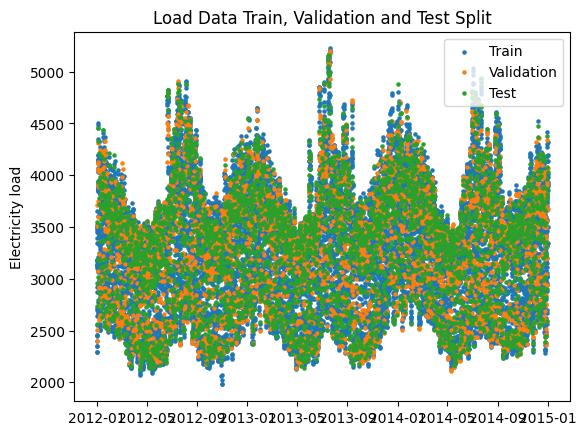

In [11]:
# Splitting the dataset randomly into train and test
train2, temp2 = train_test_split(loadts, test_size=0.3, random_state=42)  # 70% train and 30% temp
valid2, test2 = train_test_split(temp2, test_size=0.5, random_state=42)  # Split remaining temp into 50% validation and 50% test

# Plotting the train, validation, and test sets
plt.figure()
plt.scatter(train2.index, train2['load'], label='Train', s=5)
plt.scatter(valid2.index, valid2['load'], label='Validation', s=5)
plt.scatter(test2.index, test2['load'], label='Test', s=5)
plt.ylabel('Electricity load')
plt.title('Load Data Train, Validation and Test Split')
plt.legend()
plt.show()

# Scaling the data
scaler = MinMaxScaler()
train2['load'] = scaler.fit_transform(train2[['load']])
valid2['load'] = scaler.transform(valid2[['load']])
test2['load'] = scaler.transform(test2[['load']])

## 2.2.2 Build model: Gated Recurrent Unit (GRU)

In [12]:
# Preparing the training dataset for the GRU model
T = 24  # Lookback period
HORIZON = 1  # One-step-ahead prediction

train_shifted = train.copy()
train_shifted['y_t+1'] = train_shifted['load'].shift(-1, freq='h')

for t in range(1, T + 1):
    train_shifted[str(T - t)] = train_shifted['load'].shift(T - t, freq='h')

y_col = 'y_t+1'
X_cols = [f'load_t-{i}' for i in range(23, -1, -1)]
train_shifted.columns = ['load_original'] + [y_col] + X_cols
train_shifted = train_shifted.dropna(how='any')

y_train = np.array(train_shifted[y_col])
X_train = np.array(train_shifted[X_cols])
X_train = X_train.reshape(X_train.shape[0], T, 1)

# Preparing validation and test sets (similar to train_shifted)
valid_shifted = valid.copy()
test_shifted = test.copy()
for data_shifted, dataset in zip([valid_shifted, test_shifted], [valid, test]):
    data_shifted['y_t+1'] = data_shifted['load'].shift(-1, freq='h')
    for t in range(1, T + 1):
        data_shifted[str(T - t)] = data_shifted['load'].shift(T - t, freq='h')
    data_shifted.columns = ['load_original'] + [y_col] + X_cols
    data_shifted.dropna(how='any', inplace=True)

# Prepare y and X for validation and test datasets
y_valid, y_test = np.array(valid_shifted[y_col]), np.array(test_shifted[y_col])
X_valid = np.array(valid_shifted[X_cols]).reshape(-1, T, 1)
X_test = np.array(test_shifted[X_cols]).reshape(-1, T, 1)

# Building the GRU model
latent_dim = 6
batch_size = 32
epochs = 15

model_GRU = Sequential()
model_GRU.add(GRU(latent_dim, input_shape=(T, 1)))
model_GRU.add(Dense(HORIZON))
model_GRU.compile(optimizer='RMSprop', loss='mse')
model_GRU.summary()

2024-11-06 17:52:06.471977: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:152] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)
/opt/conda/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ gru (GRU)                       │ (None, 6)              │           162 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │             7 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 169 (676.00 B)

 Trainable params: 169 (676.00 B)

 Non-trainable params: 0 (0.00 B)

## 2.2.3 Fit (train) model

In [13]:
model_GRU.fit(X_train, y_train, batch_size=batch_size, epochs=epochs, verbose=2)

Epoch 1/15
730/730 - 14s - 20ms/step - loss: 0.0060
Epoch 2/15
730/730 - 12s - 17ms/step - loss: 0.0011
Epoch 3/15
730/730 - 13s - 17ms/step - loss: 7.5103e-04
Epoch 4/15
730/730 - 12s - 17ms/step - loss: 6.4605e-04
Epoch 5/15
730/730 - 12s - 17ms/step - loss: 6.0290e-04
Epoch 6/15
730/730 - 12s - 16ms/step - loss: 5.8640e-04
Epoch 7/15
730/730 - 12s - 16ms/step - loss: 5.8210e-04
Epoch 8/15
730/730 - 12s - 16ms/step - loss: 5.7902e-04
Epoch 9/15
730/730 - 12s - 16ms/step - loss: 5.7462e-04
Epoch 10/15
730/730 - 12s - 16ms/step - loss: 5.7387e-04
Epoch 11/15
730/730 - 10s - 14ms/step - loss: 5.7517e-04
Epoch 12/15
730/730 - 10s - 14ms/step - loss: 5.7109e-04
Epoch 13/15
730/730 - 10s - 14ms/step - loss: 5.7130e-04
Epoch 14/15
730/730 - 10s - 14ms/step - loss: 5.6949e-04
Epoch 15/15
730/730 - 10s - 14ms/step - loss: 5.6844e-04


## 2.2.4 Predict model

45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
Mean Absolute Percentage Error: 0.01695893647290751


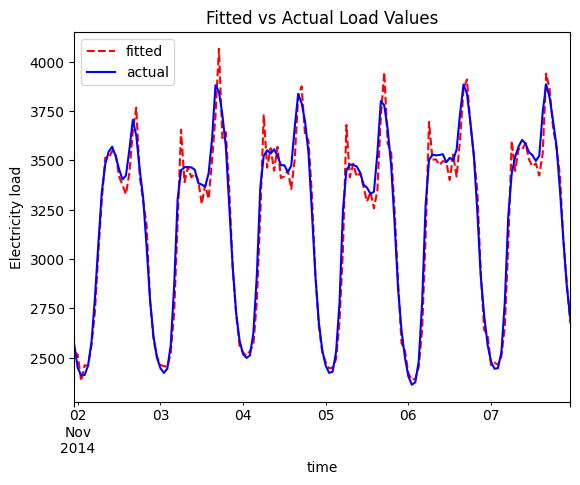

In [14]:
# Generate predictions
preds = model_GRU.predict(X_test)

# Create DataFrame for evaluation
evdta = pd.DataFrame(preds, columns=[f't+{t}' for t in range(1, HORIZON + 1)])
evdta['time'] = test_shifted.index
evdta = pd.melt(evdta, id_vars='time', value_name='fitted', var_name='h')
evdta['actual'] = np.transpose(y_test).ravel()
evdta[['fitted', 'actual']] = scaler.inverse_transform(evdta[['fitted', 'actual']])

# Error calculation
error = mean_absolute_percentage_error(evdta['actual'], evdta['fitted'])
print(f'Mean Absolute Percentage Error: {error}')

# Plotting the fitted vs actual values
evdta[evdta.time < '2014-11-08'].plot(x='time', y=['fitted', 'actual'], style=['--r', '-b'])
plt.ylabel('Electricity load')
plt.title('Fitted vs Actual Load Values')
plt.show()

## 2.2.5 Another NN model: Long-Short-Term Memory (LSTM) 

To build a first version of another type of neural network model (now LSTM), simply change the following part in the model building. In this adjusted code, we replace the GRU layer with an LSTM layer. While both GRUs and LSTMs are types of recurrent neural networks and are effective for sequence prediction problems, LSTMs have the advantage of being able to remember longer sequences due to their architecture. We will not continue with predictions using the LSTM model at this time, as it requires further hyperparameter tuning and experimentation to optimize performance before we can reliably compare its results with the previously established GRU model.

In [15]:
model_LSTM = Sequential()
model_LSTM.add(LSTM(latent_dim, input_shape=(T, 1)))
model_LSTM.add(Dense(HORIZON))
model_LSTM.compile(optimizer='RMSprop', loss='mse')
model_LSTM.summary()

/opt/conda/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 6)              │           192 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │             7 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 199 (796.00 B)

 Trainable params: 199 (796.00 B)

 Non-trainable params: 0 (0.00 B)